<a href="https://colab.research.google.com/github/Sameer-Tahir/Project_DS/blob/main/Project_DS/Lightweight_CNN_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Sameer-Tahir/Project_DS.git

Cloning into 'Project_DS'...
remote: Enumerating objects: 366, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 366 (delta 66), reused 9 (delta 9), pack-reused 268 (from 2)
Receiving objects: 100% (366/366), 25.96 MiB | 12.92 MiB/s, done.
Resolving deltas: 100% (138/138), done.


In [2]:
# Import libraries
import pandas as pd   # data processing
import numpy as np    # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# -----------------------
# Load your splits
# -----------------------
train_df = pd.read_csv("dfk1_train.csv")
val_df   = pd.read_csv("dfk1_val.csv")
test_df  = pd.read_csv("dfk1_test.csv")

In [4]:
!unzip -o dl_preprocessed.zip

Archive:  dl_preprocessed.zip
  inflating: dl_data_windows.npz     
  inflating: label_encoder.pkl       
  inflating: scaler.pkl              


In [7]:
!pip install boruta


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.0 MB/s eta 0:00:00


In [8]:
from boruta import BorutaPy

In [5]:
import numpy as np, joblib

# -----------------------
# Load preprocessed arrays
# -----------------------
data = np.load("dl_data_windows.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val     = data["X_val"],   data["y_val"]
X_test, y_test   = data["X_test"],  data["y_test"]
feature_cols     = data["feature_cols"].tolist()
classes          = data["classes"]

# Load encoder & scaler
le = joblib.load("label_encoder.pkl")
scaler = joblib.load("scaler.pkl")

print("✅ Data loaded successfully")
print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)
print("Classes:", classes)

✅ Data loaded successfully
Train: (4835, 6, 222) (4835,)
Val: (591, 6, 222) (591,)
Test: (590, 6, 222) (590,)
Classes: ['aggressive-scan' 'cryptojacking' 'icmp-flood' 'icmp-fragmentation'
 'icmp-fragmentation_old' 'none' 'os-fingerprinting' 'os-scan' 'port-scan'
 'push-ack-flood' 'serice-detection' 'service-detection' 'syn-flood'
 'syn-stealth' 'synonymous-ip-flood' 'tcp-flood' 'udp-flood' 'vuln-scan']


In [9]:
# ========== Flatten windows: (n, window, n_features) -> (n, window*n_features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat   = X_val.reshape(X_val.shape[0],   -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)

print("Flattened shapes:", X_train_flat.shape, X_val_flat.shape, X_test_flat.shape)

# ---------------------------
# χ² selector (fast, formal)
# ---------------------------
from sklearn.feature_selection import SelectKBest, chi2
# chi2 expects non-negative; your values are in [0,1] after MinMaxScaler, so fine.
k_keep = min(100, X_train_flat.shape[1])  # tune k if you want
chi2_sel = SelectKBest(score_func=chi2, k=k_keep)
X_train_chi2 = chi2_sel.fit_transform(X_train_flat, y_train)
X_val_chi2   = chi2_sel.transform(X_val_flat)
X_test_chi2  = chi2_sel.transform(X_test_flat)
print("✅ χ² kept:", X_train_chi2.shape[1])

# ---------------------------
# Boruta selector (wrapper)
# ---------------------------
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=500, max_depth=6, class_weight="balanced", n_jobs=-1, random_state=42
)
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=42)
boruta.fit(X_train_flat, y_train)
X_train_boruta = boruta.transform(X_train_flat)
X_val_boruta   = boruta.transform(X_val_flat)
X_test_boruta  = boruta.transform(X_test_flat)
print("✅ Boruta kept:", X_train_boruta.shape[1])

# Keep masks (for optional DL channel pruning)
chi2_mask   = np.zeros(X_train_flat.shape[1], dtype=bool)
chi2_mask[chi2_sel.get_support(indices=True)] = True

boruta_mask = np.zeros(X_train_flat.shape[1], dtype=bool)
boruta_mask[np.where(boruta.support_)[0]] = True

# Map flattened indices back to per-timestep feature indices
window = X_train.shape[1]
n_feat = X_train.shape[2]

def flatmask_to_feature_idx(flat_mask, window, n_feat):
    feat_idx = np.where(flat_mask)[0] % n_feat
    return sorted(np.unique(feat_idx))

chi2_feat_idx   = flatmask_to_feature_idx(chi2_mask,   window, n_feat)
boruta_feat_idx = flatmask_to_feature_idx(boruta_mask, window, n_feat)

print(f"χ² feature columns kept (per-timestep): {len(chi2_feat_idx)}")
print(f"Boruta feature columns kept (per-timestep): {len(boruta_feat_idx)}")

Flattened shapes: (4835, 1332) (591, 1332) (590, 1332)
✅ χ² kept: 100
✅ Boruta kept: 390
χ² feature columns kept (per-timestep): 27
Boruta feature columns kept (per-timestep): 162


In [11]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import json

Xtr_fs, Xva_fs, Xte_fs = X_train_boruta, X_val_boruta, X_test_boruta

lgb_model = lgb.LGBMClassifier(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=-1,
    objective="multiclass",
    class_weight="balanced",
    random_state=42
)

lgb_model.fit(
    Xtr_fs, y_train,
    eval_set=[(Xva_fs, y_val)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(20), lgb.log_evaluation(50)]  # <- replaces verbose
)

y_pred_ml   = lgb_model.predict(Xte_fs)
y_proba_ml  = lgb_model.predict_proba(Xte_fs)

acc_ml = accuracy_score(y_test, y_pred_ml)
f1_ml  = f1_score(y_test, y_pred_ml, average="macro")
print(f"🔵 LightGBM+FS  Acc={acc_ml:.4f}  MacroF1={f1_ml:.4f}")

report_ml = classification_report(y_test, y_pred_ml, target_names=classes, zero_division=0)
cm_ml     = confusion_matrix(y_test, y_pred_ml)

# Save ML results
with open("results_ml_lgb_boruta.json", "w") as f:
    json.dump({
        "accuracy": float(acc_ml),
        "macro_f1": float(f1_ml),
        "report": report_ml,
        "confusion_matrix": cm_ml.tolist()
    }, f, indent=2)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 98051
[LightGBM] [Info] Number of data points in the train set: 4835, number of used features: 390
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGBM] [Info] Start training from score -2.890372
[LightGB

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


🔵 LightGBM+FS  Acc=0.9102  MacroF1=0.7740


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.utils.class_weight import compute_class_weight

num_classes = len(classes)

# ---------- OPTIONAL: reduce feature channels for DL too (using Boruta columns)
use_feature_pruning = False  # set True to prune DL channels
if use_feature_pruning:
    keep_cols = boruta_feat_idx  # or chi2_feat_idx
    X_train_dl = X_train[:, :, keep_cols]
    X_val_dl   = X_val[:,   :, keep_cols]
    X_test_dl  = X_test[:,  :, keep_cols]
else:
    X_train_dl, X_val_dl, X_test_dl = X_train, X_val, X_test

window  = X_train_dl.shape[1]
n_feat  = X_train_dl.shape[2]

# ---------- Multiclass focal loss (correct version)
def categorical_focal_loss(gamma=2.0, alpha=None):
    """
    y_true: int labels (will be one-hot)
    y_pred: softmax probabilities
    alpha:  class weights array-like of shape [num_classes] or None
    """
    def loss(y_true, y_pred):
        y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1.0)
        ce = -tf.reduce_sum(y_true_oh * tf.math.log(y_pred), axis=-1)  # CE per sample
        p_t = tf.reduce_sum(y_true_oh * y_pred, axis=-1)               # prob of true class
        modulating = tf.pow(1.0 - p_t, gamma)
        if alpha is not None:
            alpha_t = tf.reduce_sum(y_true_oh * tf.constant(alpha, dtype=tf.float32), axis=-1)
            fl = alpha_t * modulating * ce
        else:
            fl = modulating * ce
        return tf.reduce_mean(fl)
    return loss

# ---------- Class weights -> alpha for focal loss (normalize)
cls_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
alpha = (cls_weights / np.sum(cls_weights)).astype(np.float32)  # normalize for stability
print("DL alpha (from class weights):", alpha)

# ---------- Lightweight CNN + Transformer head
def build_cnn_tr(window, n_features, n_classes, emb=64, heads=4, ff=128, blocks=2, drop=0.3):
    inp = layers.Input(shape=(window, n_features))

    # small CNN stem
    x = layers.Conv1D(96, 3, padding='same', activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(96, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2)(x)  # (window/2, 96)

    # projection to transformer dims
    x = layers.Dense(emb)(x)

    # a couple of transformer encoder blocks
    for _ in range(blocks):
        attn = layers.MultiHeadAttention(num_heads=heads, key_dim=emb)(x, x)
        x = layers.Add()([x, attn])
        x = layers.LayerNormalization()(x)

        ffw = layers.Dense(ff, activation='relu')(x)
        ffw = layers.Dense(emb)(ffw)
        x = layers.Add()([x, ffw])
        x = layers.LayerNormalization()(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(drop)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inp, out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=categorical_focal_loss(gamma=2.0, alpha=alpha),
        metrics=['accuracy']
    )
    return model

dl_model = build_cnn_tr(window, n_feat, num_classes)

early = callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)
rlr   = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)
ckpt  = callbacks.ModelCheckpoint("DL_final.keras", monitor="val_accuracy", save_best_only=True)

hist = dl_model.fit(
    X_train_dl, y_train,
    validation_data=(X_val_dl, y_val),
    epochs=60, batch_size=32,
    callbacks=[early, rlr, ckpt],
    verbose=1
)

# Evaluate
y_proba_dl = dl_model.predict(X_test_dl)
y_pred_dl  = y_proba_dl.argmax(axis=1)
acc_dl = accuracy_score(y_test, y_pred_dl)
f1_dl  = f1_score(y_test, y_pred_dl, average="macro")
print(f"🟣 DL (CNN+Transformer+Focal)  Acc={acc_dl:.4f}  MacroF1={f1_dl:.4f}")


DL alpha (from class weights): [0.03811187 0.00404851 0.05417864 0.05817075 0.11278003 0.0030165
 0.05639002 0.11757918 0.03453889 0.05417864 0.11512962 0.04978578
 0.05526222 0.04093498 0.05639002 0.05582042 0.05756481 0.0361191 ]
Epoch 1/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.6019 - loss: 0.0437 - val_accuracy: 0.7293 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 2/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7410 - loss: 0.0272 - val_accuracy: 0.7073 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 3/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.7639 - loss: 0.0236 - val_accuracy: 0.6870 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 4/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.7852 - loss: 0.0185 - val_accuracy: 0.8037 - val_loss: 0.0155 - learning_rate: 0.0010
Epoch 5/60
152/152 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8031 - loss: 0.0166 - val_accuracy: 0.8308 - val_loss: 0.0142 - learning_rate: 0.0010
E

In [13]:
# Ensure class order is the same; both use the same label encoder, so OK.
from scipy.special import softmax
# y_proba_ml: shape (n_samples, num_classes) from LightGBM
# y_proba_dl: already computed above from DL

# Simple average (you can weight, e.g., 0.6*ML + 0.4*DL)
w_ml, w_dl = 0.5, 0.5
proba_ens = w_ml * y_proba_ml + w_dl * y_proba_dl
y_pred_ens = proba_ens.argmax(axis=1)

acc_ens = accuracy_score(y_test, y_pred_ens)
f1_ens  = f1_score(y_test, y_pred_ens, average="macro")
print(f"🟢 Ensemble  Acc={acc_ens:.4f}  MacroF1={f1_ens:.4f}")


🟢 Ensemble  Acc=0.9017  MacroF1=0.7512


In [15]:
from sklearn.metrics import roc_curve, roc_auc_score


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_fscore_support, roc_curve, roc_auc_score

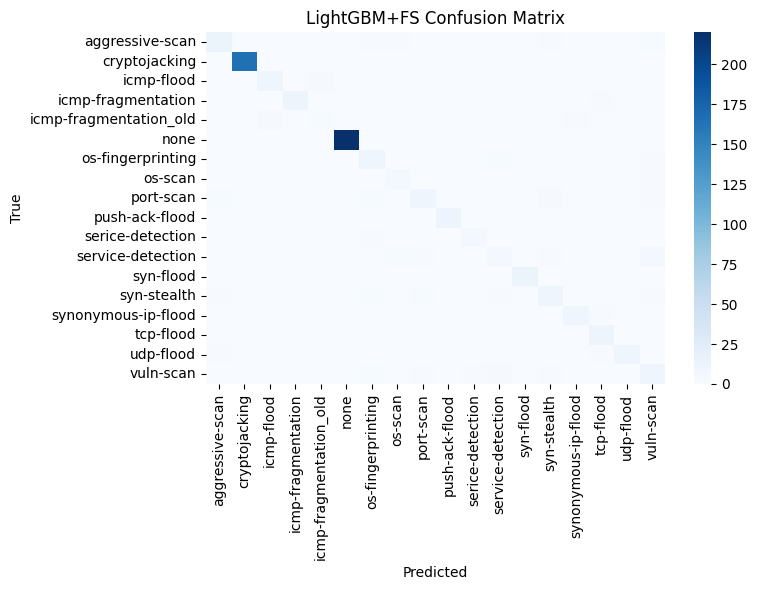

📊 Saved cm_lgb.png


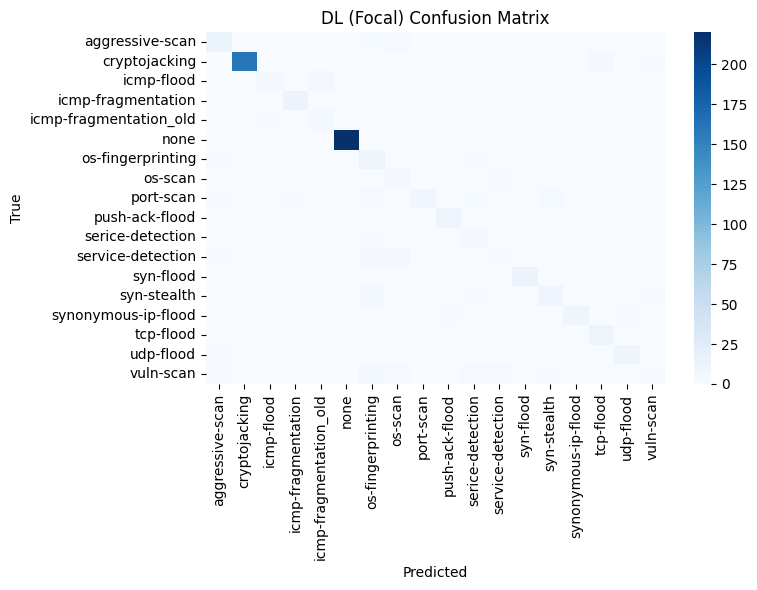

📊 Saved cm_dl.png


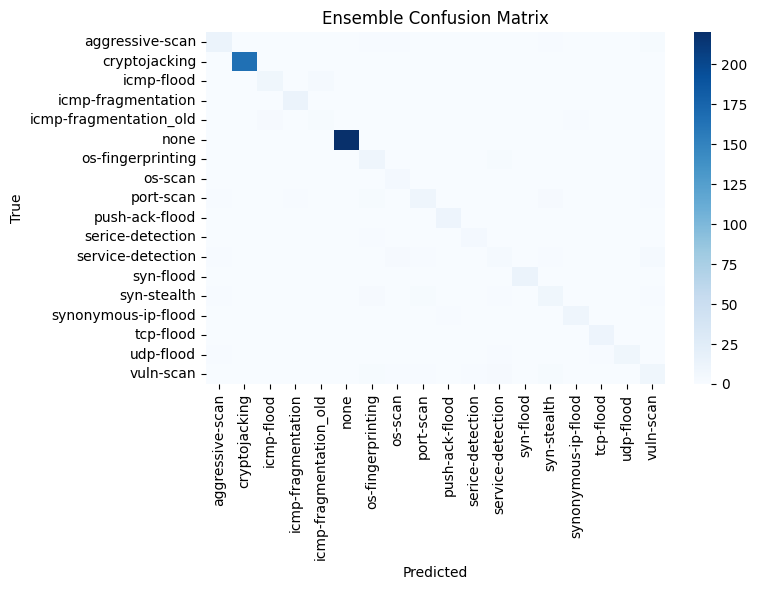

📊 Saved cm_ens.png


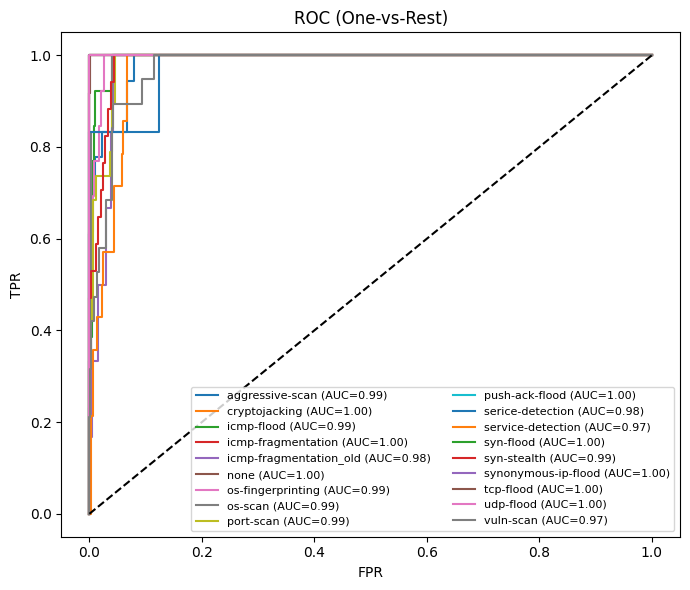

🧭 Saved roc_lgb.png


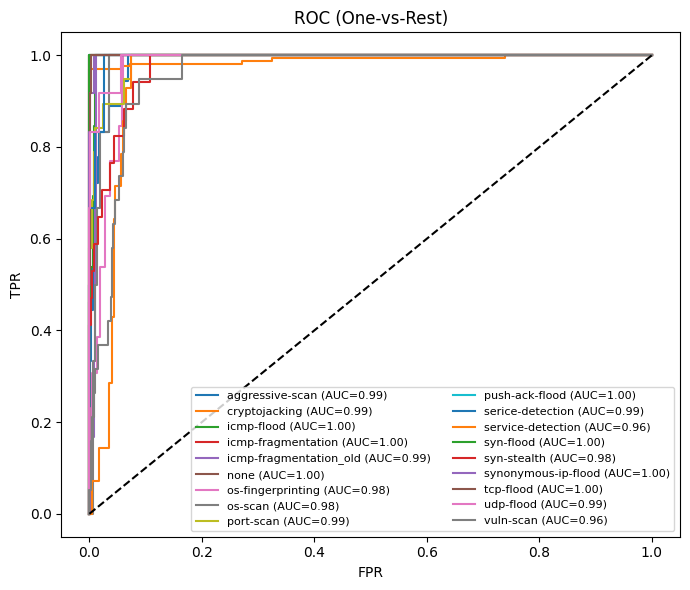

🧭 Saved roc_dl.png


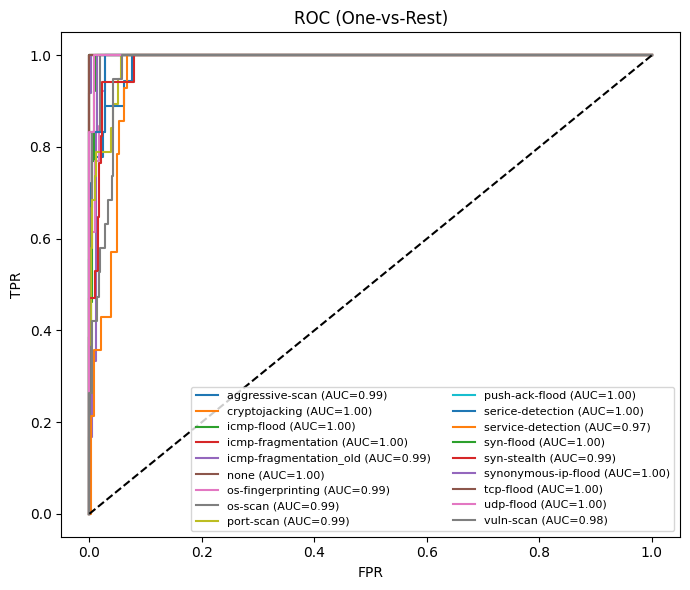

🧭 Saved roc_ens.png


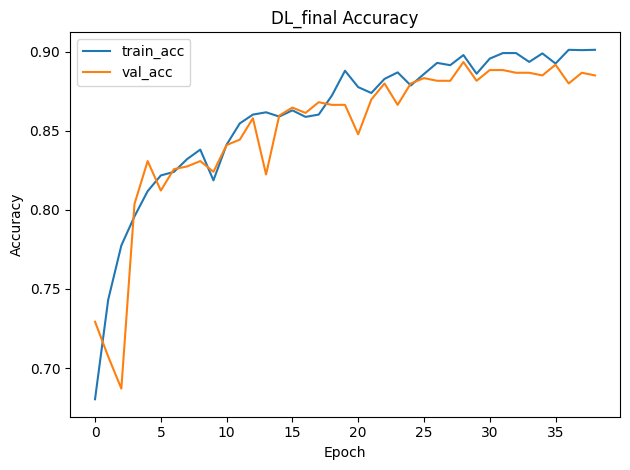

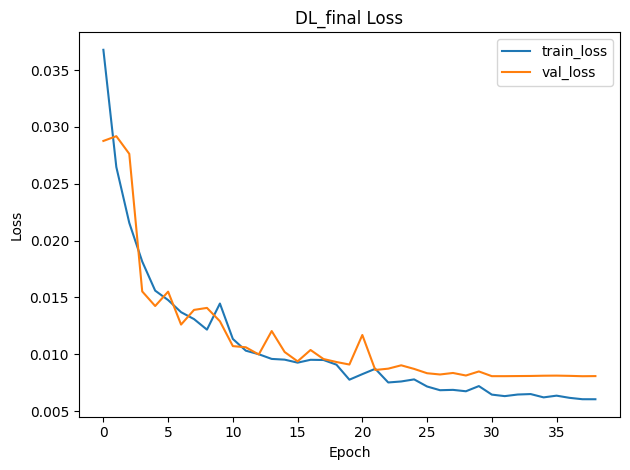

📈 Saved DL_final_accuracy.png and DL_final_loss.png
🗂️ Saved per-class CSVs: per_class_ml.csv, per_class_dl.csv, per_class_ens.csv


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

def plot_cm(cm, labels, title, filename):
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)
    plt.show()
    print(f"📊 Saved {filename}")

def plot_training_curves(history, title_prefix="DL"):
    h = history.history
    # Accuracy
    plt.figure()
    plt.plot(h["accuracy"], label="train_acc")
    plt.plot(h["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(f"{title_prefix} Accuracy")
    plt.legend(); plt.tight_layout(); plt.savefig(f"{title_prefix}_accuracy.png", dpi=200);  plt.show()
    # Loss
    plt.figure()
    plt.plot(h["loss"], label="train_loss")
    plt.plot(h["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"{title_prefix} Loss")
    plt.legend(); plt.tight_layout(); plt.savefig(f"{title_prefix}_loss.png", dpi=200);  plt.show()
    print(f"📈 Saved {title_prefix}_accuracy.png and {title_prefix}_loss.png")

def per_class_table(y_true, y_pred, label_names):
    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred, labels=range(len(label_names)))
    df = pd.DataFrame({
        "class": label_names,
        "precision": p, "recall": r, "f1": f1, "support": s
    })
    return df

# --- Confusion matrices
cm_ml  = confusion_matrix(y_test, y_pred_ml)
cm_dl  = confusion_matrix(y_test, y_pred_dl)
cm_ens = confusion_matrix(y_test, y_pred_ens)
plot_cm(cm_ml,  classes, "LightGBM+FS Confusion Matrix", "cm_lgb.png")
plot_cm(cm_dl,  classes, "DL (Focal) Confusion Matrix",   "cm_dl.png")
plot_cm(cm_ens, classes, "Ensemble Confusion Matrix",     "cm_ens.png")

# --- ROC (one-vs-rest)
def plot_multiclass_roc(y_true, proba, labels, filename):
    y_true_bin = label_binarize(y_true, classes=range(len(labels)))
    plt.figure(figsize=(7,6))
    for i, name in enumerate(labels):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], proba[:, i])
        auc = roc_auc_score(y_true_bin[:, i], proba[:, i])
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (One-vs-Rest)")
    plt.legend(fontsize=8, ncol=2)
    plt.tight_layout(); plt.savefig(filename, dpi=200);  plt.show()
    print(f"🧭 Saved {filename}")

plot_multiclass_roc(y_test, y_proba_ml,  classes, "roc_lgb.png")
plot_multiclass_roc(y_test, y_proba_dl,  classes, "roc_dl.png")
plot_multiclass_roc(y_test, proba_ens,   classes, "roc_ens.png")

# --- Training curves for DL
plot_training_curves(hist, title_prefix="DL_final")

# --- Per-class tables & save
df_ml  = per_class_table(y_test, y_pred_ml,  list(classes))
df_dl  = per_class_table(y_test, y_pred_dl,  list(classes))
df_ens = per_class_table(y_test, y_pred_ens, list(classes))

df_ml.to_csv("per_class_ml.csv",  index=False)
df_dl.to_csv("per_class_dl.csv",  index=False)
df_ens.to_csv("per_class_ens.csv",index=False)
print("🗂️ Saved per-class CSVs: per_class_ml.csv, per_class_dl.csv, per_class_ens.csv")


In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd

def evaluate_and_report(y_true, y_pred, labels, model_name, filename_prefix):
    """
    Prints confusion matrix + classification report with accuracy, macro avg, weighted avg.
    Saves CM plot + CSV, and shows inline.
    """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_cm(cm, labels, f"{model_name} Confusion Matrix", f"{filename_prefix}_cm.png")

    # Classification report
    report_dict = classification_report(
        y_true, y_pred, target_names=labels, zero_division=0, output_dict=True
    )
    report_df = pd.DataFrame(report_dict).transpose()

    # Print nicely
    print(f"\n📊 {model_name} Classification Report:\n")
    print(report_df.round(3))

    # Explicit accuracy + macro avg + weighted avg
    acc = accuracy_score(y_true, y_pred)
    print(f"\n✅ Accuracy: {acc:.4f}")
    print(f"📌 Macro Avg: {report_df.loc['macro avg', 'f1-score']:.4f}")
    print(f"📌 Weighted Avg: {report_df.loc['weighted avg', 'f1-score']:.4f}")

    # Save CSV
    report_df.to_csv(f"{filename_prefix}_report.csv")
    print(f"🗂️ Saved {filename_prefix}_report.csv")

    return cm, report_df


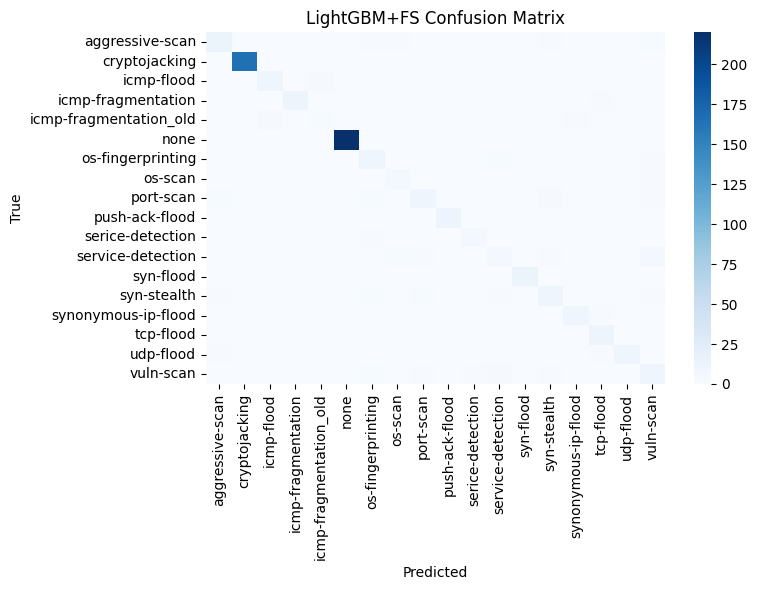

📊 Saved ml_lgb_cm.png

📊 LightGBM+FS Classification Report:

                        precision  recall  f1-score  support
aggressive-scan             0.765   0.722     0.743    18.00
cryptojacking               1.000   1.000     1.000   165.00
icmp-flood                  0.769   0.769     0.769    13.00
icmp-fragmentation          1.000   0.923     0.960    13.00
icmp-fragmentation_old      0.400   0.333     0.364     6.00
none                        1.000   1.000     1.000   220.00
os-fingerprinting           0.556   0.769     0.645    13.00
os-scan                     0.625   0.833     0.714     6.00
port-scan                   0.733   0.579     0.647    19.00
push-ack-flood              1.000   1.000     1.000    12.00
serice-detection            0.833   0.833     0.833     6.00
service-detection           0.455   0.357     0.400    14.00
syn-flood                   1.000   1.000     1.000    13.00
syn-stealth                 0.625   0.588     0.606    17.00
synonymous-ip-flood     

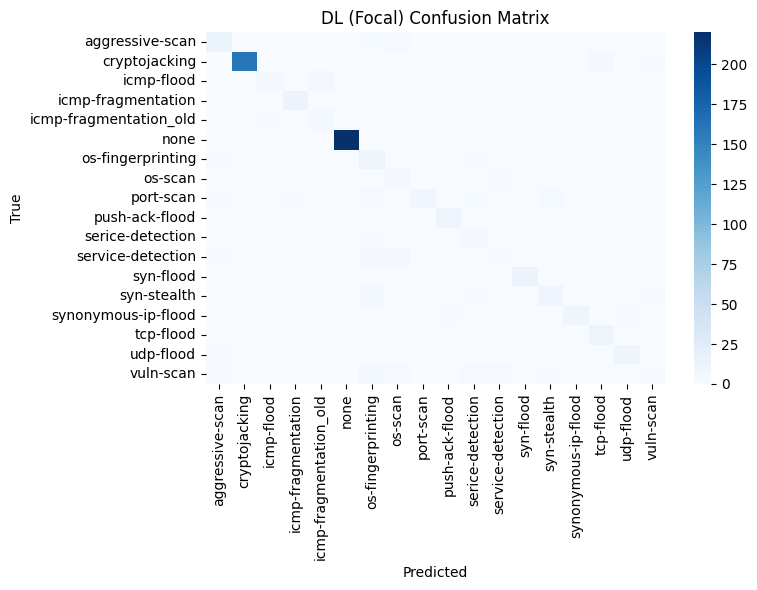

📊 Saved dl_focal_cm.png

📊 DL (Focal) Classification Report:

                        precision  recall  f1-score  support
aggressive-scan             0.684   0.722     0.703   18.000
cryptojacking               1.000   0.964     0.981  165.000
icmp-flood                  0.857   0.462     0.600   13.000
icmp-fragmentation          0.929   1.000     0.963   13.000
icmp-fragmentation_old      0.417   0.833     0.556    6.000
none                        1.000   1.000     1.000  220.000
os-fingerprinting           0.294   0.769     0.426   13.000
os-scan                     0.294   0.833     0.435    6.000
port-scan                   1.000   0.421     0.593   19.000
push-ack-flood              0.923   1.000     0.960   12.000
serice-detection            0.385   0.833     0.526    6.000
service-detection           0.200   0.071     0.105   14.000
syn-flood                   1.000   1.000     1.000   13.000
syn-stealth                 0.667   0.588     0.625   17.000
synonymous-ip-flood    

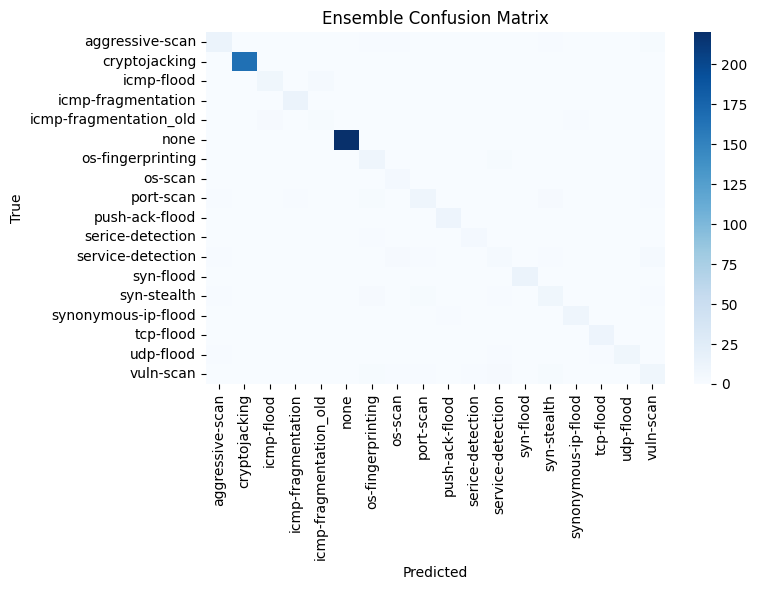

📊 Saved ens_cm.png

📊 Ensemble Classification Report:

                        precision  recall  f1-score  support
aggressive-scan             0.765   0.722     0.743   18.000
cryptojacking               1.000   1.000     1.000  165.000
icmp-flood                  0.750   0.692     0.720   13.000
icmp-fragmentation          0.929   1.000     0.963   13.000
icmp-fragmentation_old      0.333   0.333     0.333    6.000
none                        1.000   1.000     1.000  220.000
os-fingerprinting           0.526   0.769     0.625   13.000
os-scan                     0.500   0.833     0.625    6.000
port-scan                   0.733   0.579     0.647   19.000
push-ack-flood              0.923   1.000     0.960   12.000
serice-detection            0.833   0.833     0.833    6.000
service-detection           0.364   0.286     0.320   14.000
syn-flood                   1.000   1.000     1.000   13.000
syn-stealth                 0.562   0.529     0.545   17.000
synonymous-ip-flood         0.

In [26]:
cm_ml, report_ml = evaluate_and_report(y_test, y_pred_ml, classes, "LightGBM+FS", "ml_lgb")
cm_dl, report_dl = evaluate_and_report(y_test, y_pred_dl, classes, "DL (Focal)", "dl_focal")
cm_ens, report_ens = evaluate_and_report(y_test, y_pred_ens, classes, "Ensemble", "ens")



In [27]:
# ML
import joblib
joblib.dump(lgb_model, "LGBM_FS_boruta.pkl")

with open("results_lgb_boruta.json","w") as f:
    json.dump({
        "accuracy": float(acc_ml),
        "macro_f1": float(f1_ml),
        "report": classification_report(y_test, y_pred_ml, target_names=classes, zero_division=0),
        "confusion_matrix": cm_ml.tolist()
    }, f, indent=2)

# DL already saved best weights as "DL_final.keras" via ModelCheckpoint
with open("results_dl_focal.json","w") as f:
    json.dump({
        "accuracy": float(acc_dl),
        "macro_f1": float(f1_dl),
        "report": classification_report(y_test, y_pred_dl, target_names=classes, zero_division=0),
        "confusion_matrix": cm_dl.tolist()
    }, f, indent=2)

# Ensemble (no model to save, but save results)
with open("results_ensemble.json","w") as f:
    json.dump({
        "accuracy": float(acc_ens),
        "macro_f1": float(f1_ens),
        "report": classification_report(y_test, y_pred_ens, target_names=classes, zero_division=0),
        "confusion_matrix": cm_ens.tolist()
    }, f, indent=2)

print("📦 Saved: LGBM_FS_boruta.pkl, DL_final.keras, results_*.json, cm_*.png, roc_*.png, DL_final_*curves.png")


📦 Saved: LGBM_FS_boruta.pkl, DL_final.keras, results_*.json, cm_*.png, roc_*.png, DL_final_*curves.png
